# Practical Statistics for Data Scientists (Python)
# Chapter 3. Statistial Experiments and Significance Testing
> (c) 2019 Peter C. Bruce, Andrew Bruce, Peter Gedeck

Import required Python packages.

In [1]:
%matplotlib inline

from pathlib import Path
import random

import pandas as pd
import numpy as np

from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats import power

import matplotlib.pylab as plt

In [2]:
try:
    import common
    DATA = common.dataDirectory()
except ImportError:
    DATA = Path().resolve() / 'data'

Define paths to data sets. If you don't keep your data in the same directory as the code, adapt the path names.

In [3]:
WEB_PAGE_DATA_CSV = DATA / 'web_page_data.csv'
FOUR_SESSIONS_CSV = DATA / 'four_sessions.csv'
CLICK_RATE_CSV = DATA / 'click_rates.csv'
IMANISHI_CSV = DATA / 'imanishi_data.csv'

# Resampling

In [4]:
session_times = pd.read_csv(WEB_PAGE_DATA_CSV)
session_times.Time = 100 * session_times.Time

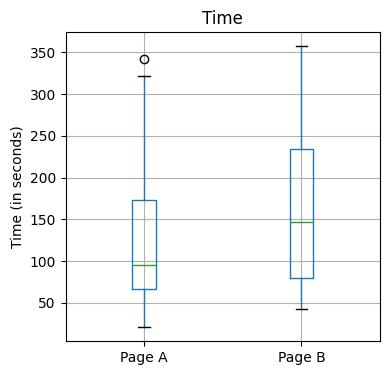

In [5]:
ax = session_times.boxplot(by='Page', column='Time',
                           figsize=(4, 4))
ax.set_xlabel('')
ax.set_ylabel('Time (in seconds)')
plt.suptitle('')

plt.tight_layout()
plt.show()

In [6]:
mean_a = session_times[session_times.Page == 'Page A'].Time.mean()
mean_b = session_times[session_times.Page == 'Page B'].Time.mean()
print(mean_b - mean_a)

35.66666666666667


The following code is different to the R version. idx_A and idx_B are reversed.

In [7]:
# Permutation test example with stickiness
def perm_fun(x, nA, nB):
    n = nA + nB
    idx_B = set(random.sample(range(n), nB))
    idx_A = set(range(n)) - idx_B
    return x.loc[list(idx_B)].mean() - x.loc[list(idx_A)].mean()
    
nA = session_times[session_times.Page == 'Page A'].shape[0]
nB = session_times[session_times.Page == 'Page B'].shape[0]
print(perm_fun(session_times.Time, nA, nB))

26.40952380952379


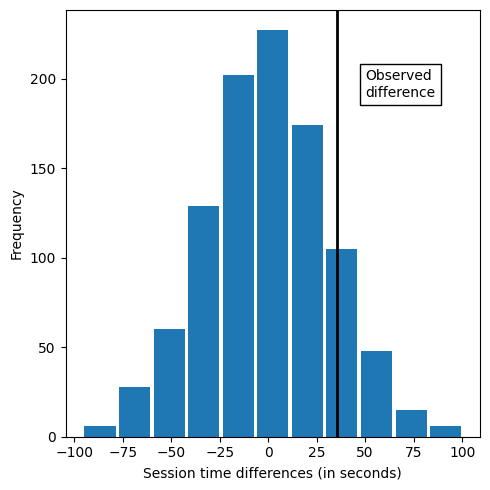

In [8]:
random.seed(1)
perm_diffs = [perm_fun(session_times.Time, nA, nB) for _ in range(1000)]

fig, ax = plt.subplots(figsize=(5, 5))
ax.hist(perm_diffs, bins=11, rwidth=0.9)
ax.axvline(x = mean_b - mean_a, color='black', lw=2)
ax.text(50, 190, 'Observed\ndifference', bbox={'facecolor':'white'})
ax.set_xlabel('Session time differences (in seconds)')
ax.set_ylabel('Frequency')

plt.tight_layout()
plt.show()

In [9]:
# convert perm_diffs to numpy array to avoid problems with some Python installations
perm_diffs = np.array(perm_diffs)
print(np.mean(perm_diffs > mean_b - mean_a))

0.121


# Statistical Significance and P-Values

Observed difference: 0.0368%


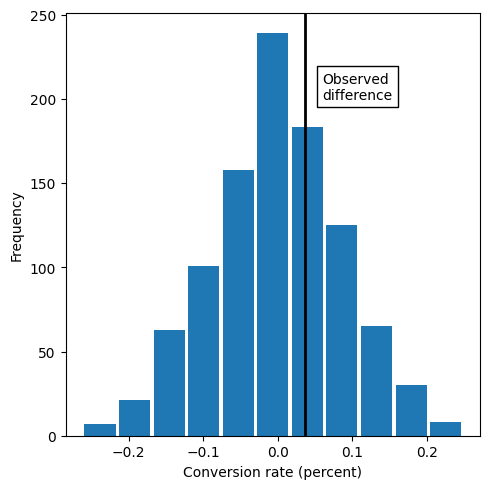

In [10]:
random.seed(1)
obs_pct_diff = 100 * (200 / 23739 - 182 / 22588)
print(f'Observed difference: {obs_pct_diff:.4f}%')
conversion = [0] * 45945
conversion.extend([1] * 382)
conversion = pd.Series(conversion)

perm_diffs = [100 * perm_fun(conversion, 23739, 22588) 
              for _ in range(1000)]

fig, ax = plt.subplots(figsize=(5, 5))
ax.hist(perm_diffs, bins=11, rwidth=0.9)
ax.axvline(x=obs_pct_diff, color='black', lw=2)
ax.text(0.06, 200, 'Observed\ndifference', bbox={'facecolor':'white'})
ax.set_xlabel('Conversion rate (percent)')
ax.set_ylabel('Frequency')

plt.tight_layout()
plt.show()

## P-Value
If `np.mean` is applied to a list of booleans, it gives the percentage of how often True was found in the list (#True / #Total).

In [11]:
print(np.mean([diff > obs_pct_diff for diff in perm_diffs]))

0.332


In [12]:
survivors = np.array([[200, 23739 - 200], [182, 22588 - 182]])
chi2, p_value, df, _ = stats.chi2_contingency(survivors)

print(f'p-value for single sided test: {p_value / 2:.4f}')

p-value for single sided test: 0.3498


# t-Tests

In [13]:
res = stats.ttest_ind(session_times[session_times.Page == 'Page A'].Time, 
                      session_times[session_times.Page == 'Page B'].Time,
                      equal_var=False)
print(f'p-value for single sided test: {res.pvalue / 2:.4f}')

p-value for single sided test: 0.1408


In [14]:
tstat, pvalue, df = sm.stats.ttest_ind(
    session_times[session_times.Page == 'Page A'].Time, 
    session_times[session_times.Page == 'Page B'].Time,
    usevar='unequal', alternative='smaller')
print(f'p-value: {pvalue:.4f}')

p-value: 0.1408


# ANOVA

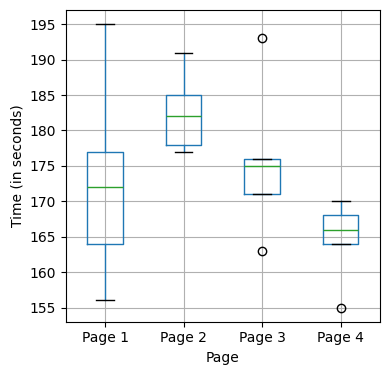

In [15]:
four_sessions = pd.read_csv(FOUR_SESSIONS_CSV)

ax = four_sessions.boxplot(by='Page', column='Time',
                           figsize=(4, 4))
ax.set_xlabel('Page')
ax.set_ylabel('Time (in seconds)')
plt.suptitle('')
plt.title('')

plt.tight_layout()
plt.show()

In [16]:
print(pd.read_csv(FOUR_SESSIONS_CSV).head())

     Page  Time
0  Page 1   164
1  Page 2   178
2  Page 3   175
3  Page 4   155
4  Page 1   172


In [17]:
observed_variance = four_sessions.groupby('Page').mean().var()[0]
print('Observed means:', four_sessions.groupby('Page').mean().values.ravel())
print('Variance:', observed_variance)
# Permutation test example with stickiness
def perm_test(df):
    df = df.copy()
    df['Time'] = np.random.permutation(df['Time'].values)
    return df.groupby('Page').mean().var()[0]
    
print(perm_test(four_sessions))

Observed means: [172.8 182.6 175.6 164.6]
Variance: 55.426666666666655
6.679999999999974


C:\Users\ediso\AppData\Local\Temp\ipykernel_33164\2694393218.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  observed_variance = four_sessions.groupby('Page').mean().var()[0]
C:\Users\ediso\AppData\Local\Temp\ipykernel_33164\2694393218.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return df.groupby('Page').mean().var()[0]


C:\Users\ediso\AppData\Local\Temp\ipykernel_33164\2694393218.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return df.groupby('Page').mean().var()[0]
C:\Users\ediso\AppData\Local\Temp\ipykernel_33164\2694393218.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return df.groupby('Page').mean().var()[0]
C:\Users\ediso\AppData\Local\Temp\ipykernel_33164\2694393218.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return df.gro

Pr(Prob) 0.083


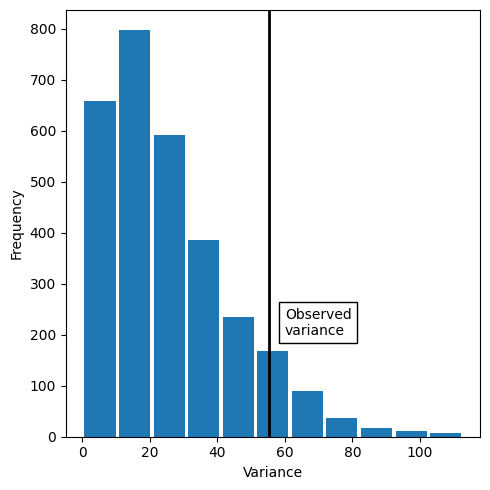

In [18]:
random.seed(1)
perm_variance = [perm_test(four_sessions) for _ in range(3000)]
print('Pr(Prob)', np.mean([var > observed_variance for var in perm_variance]))

fig, ax = plt.subplots(figsize=(5, 5))
ax.hist(perm_variance, bins=11, rwidth=0.9)
ax.axvline(x = observed_variance, color='black', lw=2)
ax.text(60, 200, 'Observed\nvariance', bbox={'facecolor':'white'})
ax.set_xlabel('Variance')
ax.set_ylabel('Frequency')

plt.tight_layout()
plt.show()

## F-Statistic
We can compute an ANOVA table using statsmodel.

In [19]:
model = smf.ols('Time ~ Page', data=four_sessions).fit()
                
aov_table = sm.stats.anova_lm(model)
print(aov_table)

            df  sum_sq     mean_sq         F    PR(>F)
Page       3.0   831.4  277.133333  2.739825  0.077586
Residual  16.0  1618.4  101.150000       NaN       NaN


In [32]:
res = stats.f_oneway(four_sessions[four_sessions.Page == 'Page 1'].Time, 
                     four_sessions[four_sessions.Page == 'Page 2'].Time,
                     four_sessions[four_sessions.Page == 'Page 3'].Time,
                     four_sessions[four_sessions.Page == 'Page 4'].Time)
print(f'F-Statistic: {res.statistic:.4f}')
print(f'p-value: {res.pvalue :.4f}')

F-Statistic: 2.7398
p-value: 0.0776


### Two-way anova only available with statsmodels
```
formula = 'len ~ C(supp) + C(dose) + C(supp):C(dose)'
model = ols(formula, data).fit()
aov_table = anova_lm(model, typ=2)
```

# Poisson

In [24]:
from scipy.stats import poisson
import pandas as pd
import matplotlib.pyplot as plt
import scipy
n = 30 # Valor razonable para poder graficar
l = 12 # Tasa de ocurrencias por unidad de tiempo. En el ejemplo, días
df = pd.DataFrame({'x': range(n)})
df['p'] = poisson.pmf(df.x, l) # fmp
df['F'] = poisson.cdf(df.x, l) # Función de distribución
df

,x,p,F
0,0,0.000006,0.000006
1,1,0.000074,0.000080
2,2,0.000442,0.000522
3,3,0.001770,0.002292
4,4,0.005309,0.007600
5,5,0.012741,0.020341
6,6,0.025481,0.045822
7,7,0.043682,0.089504
8,8,0.065523,0.155028
9,9,0.087364,0.242392


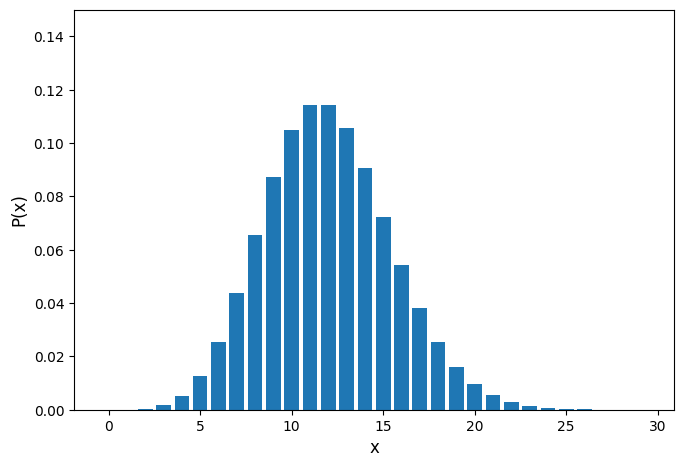

In [25]:
fig = plt.figure(figsize=[6,4])
ax = fig.add_axes([0,0,1,1])
ax.bar(df.x, df.p)
ax.set_ylabel('P(x)', fontsize=12)
ax.set_xlabel('x', fontsize=12)
plt.ylim([0, 0.15])
plt.show()

In [26]:
med, var = poisson.stats(l)
print("La media es: ", round(float(med),3), ".")
print("La varianza es: ", round(float(var),3), "\n")

La media es:  12.0 .
La varianza es:  12.0 



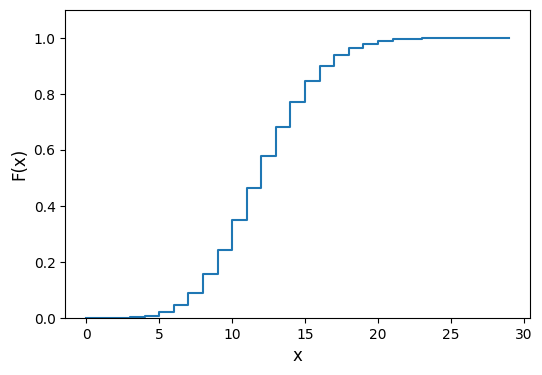

In [27]:
plt.figure(figsize=[6,4])
plt.step(df.x, df.F, where="post")
plt.ylim([0, 1.1])
plt.ylabel('F(x)', fontsize=12)
plt.xlabel('x', fontsize=12)
plt.show()

La distribución deisson se define como:

$$P(X=k) = \frac{\lambda^k e^{-\lambda}}{k!}$$

donde $\\lambda$ es el parámetro de la distribución, que representa el número promedio de eventos en un intervalo de tiempo o espacio determinado. En este caso, $\\lambda = 20$.

Podemos calcular la probabilidad de que exactamente 25 automóviles pasen por la intersección en una hora determinada utilizando la fórmula anterior:

$$P(X=25) = \frac{20^{25} e^{-20}}{25!} \\approx 0.1264$$

In [35]:
import math

def poisson_probability(lambda_, k):
    return (math.exp(-lambda_) * (lambda_ ** k)) / math.factorial(k)

lambda_ = 20 # Promedio de automóviles por hora
k = 25 # Número de automóviles

probability = poisson_probability(lambda_, k)
print(f"La probabilidad de que exactamente {k} automóviles pasen por la intersección en una hora determinada es {probability:.4f}")

La probabilidad de que exactamente 25 automóviles pasen por la intersección en una hora determinada es 0.0446


# Chi-Square Test
## Chi-Square Test: A Resampling Approach

In [21]:
# Table 3-4
click_rate = pd.read_csv(CLICK_RATE_CSV)
clicks = click_rate.pivot(index='Click', columns='Headline', values='Rate')
print(clicks)

Headline  Headline A  Headline B  Headline C
Click                                       
Click             14           8          12
No-click         986         992         988


In [22]:
# Table 3-5
row_average = clicks.mean(axis=1)
pd.DataFrame({
    'Headline A': row_average,
    'Headline B': row_average,
    'Headline C': row_average,
})

,Headline A,Headline B,Headline C
Click,,,
Click,11.333333,11.333333,11.333333
No-click,988.666667,988.666667,988.666667


In [23]:
# Resampling approach
box = [1] * 34
box.extend([0] * 2966)
random.shuffle(box)

def chi2(observed, expected):
    pearson_residuals = []
    for row, expect in zip(observed, expected):
        pearson_residuals.append([(observe - expect) ** 2 / expect
                                  for observe in row])
    # return sum of squares
    return np.sum(pearson_residuals)

expected_clicks = 34 / 3
expected_noclicks = 1000 - expected_clicks
expected = [expected_clicks, expected_noclicks]
chi2observed = chi2(clicks.values, expected)

def perm_fun(box):
    random.shuffle(box)
    sample_clicks = [sum(box[0:1000]),
                     sum(box[1000:2000]),
                     sum(box[2000:3000])]
    sample_noclicks = [1000 - n for n in sample_clicks]
    return chi2([sample_clicks, sample_noclicks], expected)

perm_chi2 = [perm_fun(box) for _ in range(2000)]

resampled_p_value = sum(perm_chi2 > chi2observed) / len(perm_chi2)
print(f'Observed chi2: {chi2observed:.4f}')
print(f'Resampled p-value: {resampled_p_value:.4f}')

Observed chi2: 1.6659
Resampled p-value: 0.4660


In [24]:
chisq, pvalue, df, expected = stats.chi2_contingency(clicks)
print(f'Observed chi2: {chisq:.4f}')
print(f'p-value: {pvalue:.4f}')

Observed chi2: 1.6659
p-value: 0.4348


The above algorithm uses sampling into the three sets without replacement. Alternatively, it is also possible to sample with replacement.

In [25]:
expected = [expected_clicks, expected_noclicks]
def sample_with_replacement(box):
    sample_clicks = [sum(random.sample(box, 1000)),
                     sum(random.sample(box, 1000)),
                     sum(random.sample(box, 1000))]
    sample_noclicks = [1000 - n for n in sample_clicks]
    return chi2([sample_clicks, sample_noclicks], expected)

perm_chi2 = [sample_with_replacement(box) for _ in range(2000)]

resampled_p_value = sum(perm_chi2 > chi2observed) / len(perm_chi2)
print(f'Observed chi2: {chi2observed:.4f}')
print(f'Resampled p-value: {resampled_p_value:.4f}')

Observed chi2: 1.6659
Resampled p-value: 0.4845


## Figure chi-sq distribution

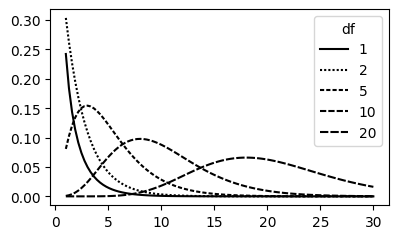

In [26]:
x = [1 + i * (30 - 1) / 99 for i in range(100)]

chi = pd.DataFrame({
    'x': x,
    'chi_1': stats.chi2.pdf(x, df=1),
    'chi_2': stats.chi2.pdf(x, df=2),
    'chi_5': stats.chi2.pdf(x, df=5),
    'chi_10': stats.chi2.pdf(x, df=10),
    'chi_20': stats.chi2.pdf(x, df=20),
})
fig, ax = plt.subplots(figsize=(4, 2.5))
ax.plot(chi.x, chi.chi_1, color='black', linestyle='-', label='1')
ax.plot(chi.x, chi.chi_2, color='black', linestyle=(0, (1, 1)), label='2')
ax.plot(chi.x, chi.chi_5, color='black', linestyle=(0, (2, 1)), label='5')
ax.plot(chi.x, chi.chi_10, color='black', linestyle=(0, (3, 1)), label='10')
ax.plot(chi.x, chi.chi_20, color='black', linestyle=(0, (4, 1)), label='20')
ax.legend(title='df')

plt.tight_layout()
plt.show()

## Fisher's Exact Test
Scipy has only an implementation of Fisher's Exact test for 2x2 matrices. There is a github repository that provides a Python implementation that uses the same code as the R version. Installing this requires a Fortran compiler. 
```
stats.fisher_exact(clicks)
```

In [27]:
# stats.fisher_exact(clicks.values)

### Scientific Fraud

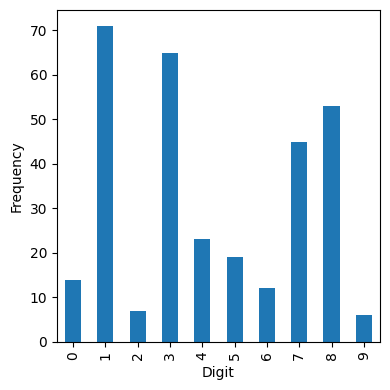

In [28]:
imanishi = pd.read_csv(IMANISHI_CSV)
imanishi.columns = [c.strip() for c in imanishi.columns]
ax = imanishi.plot.bar(x='Digit', y=['Frequency'], legend=False,
                      figsize=(4, 4))
ax.set_xlabel('Digit')
ax.set_ylabel('Frequency')

plt.tight_layout()
plt.show()

# Power and Sample Size
statsmodels has a number of methods for power calculation

see e.g.: https://machinelearningmastery.com/statistical-power-and-power-analysis-in-python/

In [29]:
effect_size = sm.stats.proportion_effectsize(0.0121, 0.011)
analysis = sm.stats.TTestIndPower()
result = analysis.solve_power(effect_size=effect_size, 
                              alpha=0.05, power=0.8, alternative='larger')
print('Sample Size: %.3f' % result)

Sample Size: 116602.393


In [30]:
effect_size = sm.stats.proportion_effectsize(0.0165, 0.011)
analysis = sm.stats.TTestIndPower()
result = analysis.solve_power(effect_size=effect_size, 
                              alpha=0.05, power=0.8, alternative='larger')
print('Sample Size: %.3f' % result)

Sample Size: 5488.408
